<a href="https://colab.research.google.com/github/danyssilva/ANN/blob/main/MNIST_CONV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import gzip
import shutil

def extrair_gz_simples(arquivo_gz, dir_dest="."):
    with gzip.open(arquivo_gz, 'rb') as f_in:
        with open(os.path.join(dir_dest, os.path.basename(arquivo_gz)[:-3]), 'wb') as f_out:
            f_out.write(f_in.read())


In [2]:
# !wget 'http://yann.lecun.com/exdb/mnist'
# Training Images
!wget 'https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz'
# Training Labels
!wget 'https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz'

# Testing Images
!wget 'https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz'
# Testing Labels
!wget 'https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz'

--2025-07-07 13:08:51--  https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.207, 172.217.203.207, 142.250.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  27.1MB/s    in 0.3s    

2025-07-07 13:08:52 (27.1 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2025-07-07 13:08:52--  https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.207, 172.217.203.207, 142.250.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [a

In [3]:
extrair_gz_simples("train-images-idx3-ubyte.gz", ".")
extrair_gz_simples("train-labels-idx1-ubyte.gz", ".")
extrair_gz_simples("t10k-images-idx3-ubyte.gz", ".")
extrair_gz_simples("t10k-labels-idx1-ubyte.gz", ".")

In [22]:
import numpy as np
import os

def carregar_mnist(diretorio):
    """
    Carrega os dados do conjunto MNIST a partir dos arquivos extraídos.

    Parâmetro:
    diretorio : str
        Caminho para o diretório onde os arquivos MNIST estão localizados.

    Retorna:
    xtrain : np.ndarray
        Imagens de treinamento.
    ytrain : np.ndarray
        Rótulos de treinamento.
    xtest : np.ndarray
        Imagens de teste.
    ytest : np.ndarray
        Rótulos de teste.
    """
    # Caminhos dos arquivos
    caminho_treinamento_imagens = os.path.join(diretorio, 'train-images-idx3-ubyte')
    caminho_treinamento_rotulos = os.path.join(diretorio, 'train-labels-idx1-ubyte')
    caminho_teste_imagens = os.path.join(diretorio, 't10k-images-idx3-ubyte')
    caminho_teste_rotulos = os.path.join(diretorio, 't10k-labels-idx1-ubyte')

    # Função para ler imagens
    def ler_imagens(caminho):
        with open(caminho, 'rb') as f:
            f.read(16)  # Ignora o cabeçalho
            imagens = np.frombuffer(f.read(), dtype=np.uint8)
            imagens = imagens.reshape(-1, 28, 28)  # Reshape para (n_samples, 28, 28)
        return imagens

    # Função para ler rótulos
    def ler_rotulos(caminho):
        with open(caminho, 'rb') as f:
            f.read(8)  # Ignora o cabeçalho
            rotulos = np.frombuffer(f.read(), dtype=np.uint8)
        return rotulos

    # Carregar os dados
    train_images = ler_imagens(caminho_treinamento_imagens)
    train_labels = ler_rotulos(caminho_treinamento_rotulos)
    test_images = ler_imagens(caminho_teste_imagens)
    test_labels = ler_rotulos(caminho_teste_rotulos)

    return train_images, train_labels, test_images, test_labels

In [23]:
train_images, train_labels, test_images, test_labels = carregar_mnist('.')

5


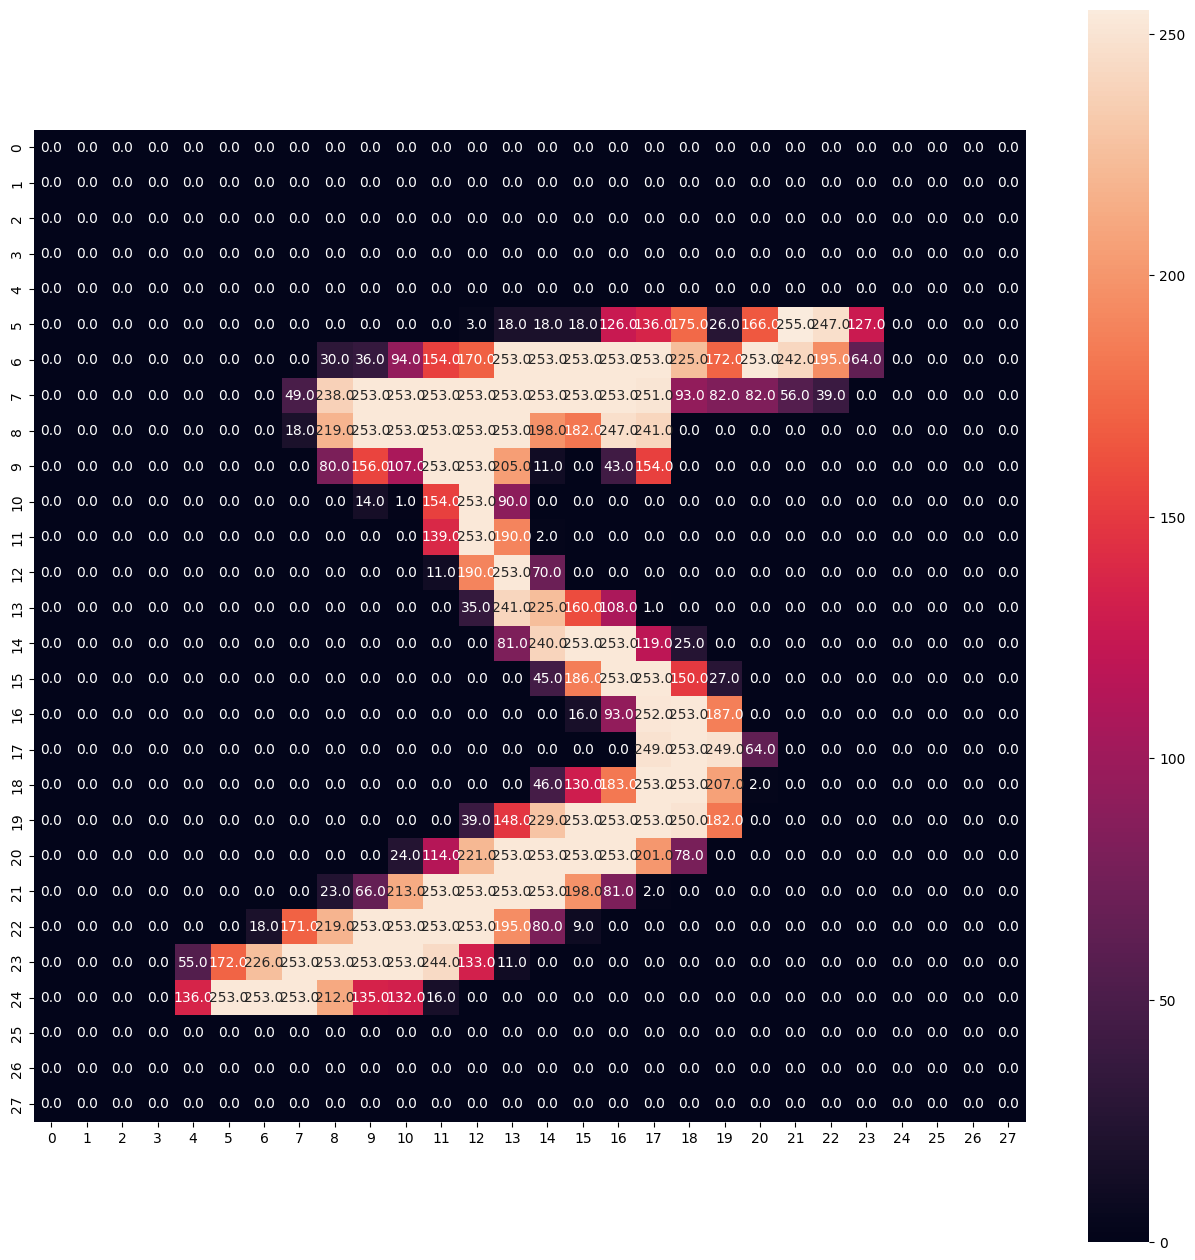

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

print(train_labels[0])
f, ax = plt.subplots(figsize=(16, 16))
sns.heatmap(train_images[0], annot=True, fmt='.1f', square=True)
plt.show()

In [25]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, ClassifierMixin
import torch
from sklearn.metrics import accuracy_score

In [26]:
class ConvArquitetura(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(ConvArquitetura, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128 * 7 * 7, output_shape)  # Ajuste conforme necessário

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.flatten(x)
        x = F.softmax(self.fc(x), dim=1)
        return x

# Inicializando o modelo
input_shape = (1, 28, 28)  # Formato esperado para PyTorch (C, H, W)
output_shape = 10
model = ConvArquitetura(input_shape, output_shape)

# Exibir resumo do modelo
print(model)

ConvArquitetura(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=6272, out_features=10, bias=True)
)


In [27]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

class Divide255(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    return X / 255.0

class TransformaShape(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    return X.reshape(-1, 1, 28, 28)


In [28]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [29]:
import numpy as np
class RedeNeuralConv(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=5, batch_size=128, modelFactory=ConvArquitetura):
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
        self.labels = None
        self.optimizer = None
        self.criterion = nn.CrossEntropyLoss()
        self.verbose = 1
        self.modelFactory = modelFactory

    def fit(self, X, y):
        X = torch.from_numpy(X).float()
        self.labels, ids = np.unique(y, return_inverse=True)
        y_tensor = torch.tensor(ids, dtype=torch.long)

        num_classes = len(self.labels)
        self.model = self.modelFactory(X.shape[1:], num_classes)
        self.model.to(device)
        self.optimizer = optim.RMSprop(self.model.parameters(), lr=0.001)

        dataset = torch.utils.data.TensorDataset(X, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            for images, labels in dataloader:
                images = images.to(device)
                labels = labels.to(device)
                self.optimizer.zero_grad()
                output = self.model(images)
                loss = self.criterion(output, labels)
                loss.backward()
                self.optimizer.step()

            if self.verbose > 0:
                print(f"Epoch {epoch+1}/{self.epochs}, Loss: {loss.item():.4f}")


    def predict(self, X):
        with torch.no_grad():
            X_tensor = torch.from_numpy(X).float().to(device)
            output = self.model(X_tensor).cpu().numpy()
            ypred = self.labels[output.argmax(axis=1)]
            return ypred

modelo = Pipeline([
    ("scaler", Divide255()),
    ("reshape", TransformaShape()),
    ("ann", RedeNeuralConv())
])

modelo.fit(train_images, train_labels)
ypred = modelo.predict(test_images)
accuracy_score(test_labels, ypred)

Epoch 1/5, Loss: 1.7295
Epoch 2/5, Loss: 1.5223
Epoch 3/5, Loss: 1.4736
Epoch 4/5, Loss: 1.4716
Epoch 5/5, Loss: 1.4715


/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


0.9888